In [1]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
import numpy
import PIL
from PIL import Image
np.random.seed(1337)  # for reproducibility

import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.optimizers import RMSprop
from keras import backend as K
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate


def euclidean_distance(x, y):
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def conc(vects):
    x, y = vects
    conc1 = concatenate([x,y])
    return conc1

def conc_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],32)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    x = y_pred[:,0:128]
    y = y_pred[:,128:268]
    y_pred1 = euclidean_distance(x,y)
    p = x
    q = y
    p = K.clip(p, K.epsilon(), 1)
    q = K.clip(q, K.epsilon(), 1)
    #y_true1 = y_true[:,0]
    #y_true1 = K.reshape(y_true1,(-1,))
    #print(y_true1)
    #tr_same = y_true[:,1]
    #tr_same = K.reshape(tr_same, (-1,))
    y_true1 = y_true
    tr_same = K.round(y_true/3)
    margin = 1
    test = 0.001*K.sum(p*K.abs(K.log(p)-K.log(q)), axis=1)

    return K.mean((1-tr_same)*(y_true1 * K.square(y_pred1) + (1 - y_true1) * K.square(K.maximum(margin - y_pred1, 0)))
                 + (tr_same)*test)

def triplet_loss(y_true, y_pred):
    x = y_pred[:,0:32]
    y = y_pred[:,32:64]
    y_pred1 = euclidean_distance(x,y)
    y_true1 = y_true
    margin = 1
    return K.mean(y_true1 * K.square(y_pred1) + (1 - y_true1) * K.square(K.maximum(margin - y_pred1, 0)))

def coral_loss(y_true, y_pred):
    x = y_pred[:,0:32]
    y = y_pred[:,32:64]
    n = 32.0
    mul1 = K.dot(K.transpose(x),x)
    one = x*0+1
    mul2 = K.dot(K.transpose(one), x)
    sub = K.dot(K.transpose(mul2), mul2)
    source = (mul1 - (sub)/n)/(n-1)
    #source = K.abs(source)
    source = K.clip(source, K.epsilon(),10000)
    #source1 = K.log(source)
    
    mul11 = K.dot(K.transpose(y),y)
    mul21 = K.dot(K.transpose(one), y)
    sub1 = K.dot(K.transpose(mul2), mul2)
    n = float(n)
    target = (mul11 - (sub1)/n)/(n-1)
    #target = K.abs(target)
    target = K.clip(target, K.epsilon(),10000)
    #target1 = K.log(target)
    
    return (K.sum(K.dot((source-target),(source-target)))/(4*32.0))
       
    

def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(7)]) - 1
    for d in range(7):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1,7)
            dn = (d + inc) % 7
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

def create_addi_pairs(x, y):
    pairs = []
    labels = []
    for i in range(0,1000):
        k1 = random.randrange(0,x.shape[0])
        for j in range(0,10):
            k2 = random.randrange(0, y.shape[0])
            pairs+= [[x[k1],y[k2]]]
            labels += [3]
    return np.array(pairs), np.array(labels)
             
            
def create_base_network():
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    seq.add(Dense(64, input_shape=(64,), activation='relu'))
    #seq.add(Dense(64, activation='relu'))
    seq.add(Dense(32, activation='relu'))
    seq.add(Dense(32, activation='relu'))
    return seq


def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return labels[predictions.ravel() < 0.5].mean()



/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import scipy.io
mat = scipy.io.loadmat('/home/aniruddha/deep-learning-projects/Siamese_Networks/Dataset/PaviaCentre.mat')
arr = mat['pavia']
arr = np.array(arr)
print(arr.shape)

import scipy.io
mat = scipy.io.loadmat('/home/aniruddha/deep-learning-projects/Siamese_Networks/Dataset/PaviaCentre_gt.mat')
arr1 = mat['pavia_gt']
arr1 = np.array(arr1)
print(arr1.shape)

a=[]
label=[]
k=0
for i in range(0,arr1.shape[0]):
    for j in range(0,arr1[i].shape[0]):
        a.append(arr[i][j])
        label.append(arr1[i][j])
        
a=np.array(a)
label=np.array(label)

X_train=[]
y_train=[]
for i in range (0,a.shape[0]):
    if(label[i]==2):
        y_train.append(0)
    if(label[i]==3):
        y_train.append(1)
    if(label[i]==4):
        y_train.append(2)
    if(label[i]==5):
        y_train.append(3)
    if(label[i]==7):
        y_train.append(4)
    if(label[i]==8):
        y_train.append(5)
    if(label[i]==9):
        y_train.append(6)
    if (label[i]==2 or label[i]==3 or label[i]==4 or label[i]==5 or label[i]==7 or label[i]==8 or label[i]==9):
        X_train.append(a[i])
X_train=np.array(X_train)
y_train=np.array(y_train)
print(X_train.shape)
print(y_train.shape)

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state = 0)

from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
from sklearn.decomposition import PCA
pca = PCA(n_components=64)
X_train = pca.fit_transform(X_train)
print(X_train.shape)


(1096, 715, 102)
(1096, 715)
(72933, 102)
(72933,)


/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(72933, 64)


In [4]:
np.savetxt("/home/aniruddha/deep-learning-projects/Siamese_Networks/Dataset/PaviaCentre1.csv", X_train,delimiter="," )
np.savetxt("/home/aniruddha/deep-learning-projects/Siamese_Networks/Dataset/PaviaCentre_gt1.csv", y_train,delimiter="," )

In [5]:
print(label.max())

9


In [6]:
import scipy.io
mat = scipy.io.loadmat('/home/aniruddha/deep-learning-projects/Siamese_Networks/Dataset/PaviaU.mat')
arr = mat['paviaU']
arr = np.array(arr)

import scipy.io
mat = scipy.io.loadmat('/home/aniruddha/deep-learning-projects/Siamese_Networks/Dataset/PaviaU_gt.mat')
arr1 = mat['paviaU_gt']
arr1 = np.array(arr1)
print(arr1.shape)

a=[]
label=[]
k=0
for i in range(0,arr1.shape[0]):
    for j in range(0,arr1[i].shape[0]):
        a.append(arr[i][j])
        label.append(arr1[i][j])
        
a=np.array(a)
label=np.array(label)
print(a.shape)
print(label.shape)

X_train1=[]
y_train1=[]
for i in range (0,a.shape[0]):
    if(label[i]==4):
        y_train1.append(0)
    if(label[i]==1):
        y_train1.append(1)
    if(label[i]==8):
        y_train1.append(2)
    if(label[i]==7):
        y_train1.append(3)
    if(label[i]==9):
        y_train1.append(4)
    if(label[i]==2):
        y_train1.append(5)
    if(label[i]==6):
        y_train1.append(6)
    if (label[i]==4 or label[i]==1 or label[i]==8 or label[i]==7 or label[i]==9 or label[i]==2 or label[i]==6):
        X_train1.append(a[i])
X_train1=np.array(X_train1)
y_train1=np.array(y_train1)

from sklearn.utils import shuffle
X_train1, y_train1 = shuffle(X_train1, y_train1, random_state = 0)
from sklearn.preprocessing import StandardScaler
X_train1 = StandardScaler().fit_transform(X_train1)
from sklearn.decomposition import PCA
pca = PCA(n_components=64)
X_train1 = pca.fit_transform(X_train1)
print(X_train1.shape)


(610, 340)
(207400, 103)
(207400,)


/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(39332, 64)


In [8]:
np.savetxt("/home/aniruddha/deep-learning-projects/Siamese_Networks/Dataset/PaviaU1.csv", X_train1,delimiter="," )
np.savetxt("/home/aniruddha/deep-learning-projects/Siamese_Networks/Dataset/PaviaU_gt1.csv", y_train1,delimiter="," )

In [5]:
print(X_train.max())
print(X_train1.max())
X_train=X_train.astype('float32')
X_train1=X_train1.astype('float32')

47.423585702771796
104.56701566525479


In [6]:
print(X_train.min())
print(X_train1.min())

-19.61208
-19.46586


In [7]:
X_train=X_train/100
X_train1=X_train1/100

In [8]:
X_test=X_train1[20000:39332,:]
y_test=y_train1[20000:39332]
X_train1=X_train1[0:20000,:]
y_train1=y_train1[0:20000]

print(X_train1.shape)
print(X_test.shape)

(20000, 64)
(19332, 64)


In [9]:
print((X_train).max())
print(abs(X_train1).max())
print(abs(X_test).max())
print(X_train.min())
print(X_train1.min())

0.47423583
0.4411732
1.0456702
-0.1961208
-0.1944266


In [10]:
digit_indices = [np.where(y_train == i)[0] for i in range(7)]
tr_pairs, tr_y = create_pairs(X_train, digit_indices)

In [11]:
tr1_pairs, tr1_y = create_addi_pairs(X_train, X_train1)

In [12]:
print(tr_pairs.shape)
print(tr1_pairs.shape)

(37576, 2, 64)
(10000, 2, 64)


In [13]:

# network definition
input_dim=X_train.shape[1:]
base_network = create_base_network()

input_a = Input(shape=input_dim)
input_b = Input(shape=input_dim)

#input_a=K.reshape(input_a,(28,28,1))
#input_b=K.reshape(input_b,(28,28,1))
# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
print(input_b.shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(conc, output_shape=conc_shape)([processed_a, processed_b])
print(distance.shape)

model = Model(input=[input_a, input_b], output=distance)

(?, 64)
(?, 64)


/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("la..., inputs=[<tf.Tenso...)`


In [14]:
test_model = Model(input = input_a, output = processed_a)

/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("se..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


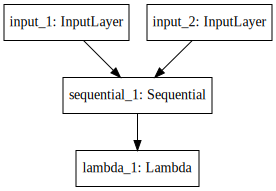

In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [16]:
print(tr_pairs[:,0].shape)
print(tr_pairs[:,1].shape)
print(tr_y.shape)

(37576, 64)
(37576, 64)
(37576,)


In [17]:
# train
from keras import optimizers
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
rms = RMSprop()
for i in range(0,50):
     model.compile(loss=triplet_loss, optimizer=rms)
     model.fit([tr_pairs[:,0], tr_pairs[:, 1]], tr_y, batch_size=64, nb_epoch=1)
     model.compile(loss=coral_loss, optimizer=rms)
     model.fit([tr1_pairs[:,0], tr1_pairs[:, 1]], tr1_y, batch_size=64, nb_epoch=1)
     

        

/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Epoch 1/1
37576/37576 [==============================] - 3s 71us/step - loss: 0.0922


/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Epoch 1/1
10000/10000 [==============================] - 1s 68us/step - loss: 1.5502e-07
Epoch 1/1
37576/37576 [==============================] - 2s 49us/step - loss: 0.0636
Epoch 1/1
10000/10000 [==============================] - 1s 60us/step - loss: 1.4326e-08
Epoch 1/1
37576/37576 [==============================] - 2s 58us/step - loss: 0.0501
Epoch 1/1
10000/10000 [==============================] - 1s 78us/step - loss: 6.1621e-10
Epoch 1/1
37576/37576 [==============================] - 2s 53us/step - loss: 0.0438
Epoch 1/1
10000/10000 [==============================] - 1s 68us/step - loss: 1.2498e-07
Epoch 1/1
37576/37576 [==============================] - 2s 53us/step - loss: 0.0397
Epoch 1/1
10000/10000 [==============================] - 1s 73us/step - loss: 2.0334e-13
Epoch 1/1
37576/37576 [==============================] - 2s 55us/step - loss: 0.0367
Epoch 1/1
10000/10000 [==============================] - 1s 86us/step - loss: 8.3828e-11
Epoch 1/1
37576/37576 [==================

In [20]:
processed=test_model.predict(X_train1)
print(processed[100])
print(processed[100].shape)

[0.2657632  0.38469705 0.45765868 0.         0.40599066 0.38079298
 0.31975287 0.         0.32441968 0.         0.30818826 0.46019822
 0.01177879 0.2807541  0.06151529 0.         0.         0.15642351
 0.         0.         0.3702855  0.4606436  0.43249655 0.29456252
 0.2968273  0.36736238 0.03106957 0.         0.         0.34328732
 0.3173918  0.41384408]
(32,)


In [19]:
from keras.utils import np_utils
y_tr = np_utils.to_categorical(y_train)
y_tr1 = np_utils.to_categorical(y_train1)
y_te = np_utils.to_categorical(y_test)
num_classes = 7
print(y_tr.shape)
print(y_tr1.shape)
print(y_te.shape)

(72933, 7)
(20000, 7)
(19332, 7)


In [24]:
num_pixels = 32
# define baseline model
def baseline_model1():
	# create model
	model = Sequential()
	model.add(Dense(32, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
	model.add(Dense(16, kernel_initializer='normal', activation='relu'))
	model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [22]:
processed_train = test_model.predict(X_train)
processed_train1 = test_model.predict(X_train1)
processed_test = test_model.predict(X_test)
print(processed_train.shape)
print(processed_train1.shape)
print(processed_test.shape)

(72933, 32)
(20000, 32)
(19332, 32)


In [25]:

# build the model
model1 = baseline_model1()
# Fit the model
model1.fit(processed_train, y_tr, validation_data=(processed_train1, y_tr1), epochs=100, batch_size=128, verbose=1)
# Final evaluation of the model



Train on 72933 samples, validate on 20000 samples
Epoch 1/100
72933/72933 [==============================] - 4s 59us/step - loss: 0.5285 - acc: 0.8567 - val_loss: 5.6973 - val_acc: 0.4688
Epoch 2/100
72933/72933 [==============================] - 2s 30us/step - loss: 0.0378 - acc: 0.9919 - val_loss: 6.3764 - val_acc: 0.4710
Epoch 3/100
72933/72933 [==============================] - 2s 30us/step - loss: 0.0331 - acc: 0.9920 - val_loss: 6.6271 - val_acc: 0.4703
Epoch 4/100
72933/72933 [==============================] - 2s 29us/step - loss: 0.0321 - acc: 0.9918 - val_loss: 6.7839 - val_acc: 0.4733
Epoch 5/100
72933/72933 [==============================] - 2s 30us/step - loss: 0.0317 - acc: 0.9920 - val_loss: 6.8547 - val_acc: 0.4714
Epoch 6/100
72933/72933 [==============================] - 2s 32us/step - loss: 0.0313 - acc: 0.9922 - val_loss: 6.9403 - val_acc: 0.4701
Epoch 7/100
72933/72933 [==============================] - 3s 34us/step - loss: 0.0310 - acc: 0.9922 - val_loss: 6.9827 - 

In [126]:
#logCORAL
scores_train = model1.evaluate(processed_train, y_tr, verbose=1)
scores_test = model1.evaluate(processed_test, y_te, verbose=1)
print('* Accuracy on training set: %0.2f%%' % (100 * scores_train[1]))
print('* Accuracy on test set: %0.2f%%' % (100 * scores_test[1]))

19332/19332 [==============================] - 1s 58us/step
* Accuracy on training set: 77.18%
* Accuracy on test set: 42.16%


In [142]:
#CORAL
scores_train = model1.evaluate(processed_train, y_tr, verbose=1)
scores_test = model1.evaluate(processed_test, y_te, verbose=1)
print('* Accuracy on training set: %0.2f%%' % (100 * scores_train[1]))
print('* Accuracy on test set: %0.2f%%' % (100 * scores_test[1]))

19332/19332 [==============================] - 1s 68us/step
* Accuracy on training set: 98.71%
* Accuracy on test set: 43.58%


In [25]:
#64 output dim
#CORAL
scores_train = model1.evaluate(processed_train, y_tr, verbose=1)
scores_test = model1.evaluate(processed_test, y_te, verbose=1)
print('* Accuracy on training set: %0.2f%%' % (100 * scores_train[1]))
print('* Accuracy on test set: %0.2f%%' % (100 * scores_test[1]))

19332/19332 [==============================] - 0s 25us/step
* Accuracy on training set: 58.72%
* Accuracy on test set: 47.28%


In [26]:
#32 output dim new
#CORAL
# acc 47.72
scores_train = model1.evaluate(processed_train, y_tr, verbose=1)
scores_test = model1.evaluate(processed_test, y_te, verbose=1)
print('* Accuracy on training set: %0.2f%%' % (100 * scores_train[1]))
print('* Accuracy on test set: %0.2f%%' % (100 * scores_test[1]))

19332/19332 [==============================] - 1s 44us/step
* Accuracy on training set: 99.27%
* Accuracy on test set: 46.63%
